In [107]:
%reload_ext autoreload
%autoreload 2

In [146]:
### imports
# general
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# custom
import utils, plotting, analysis
from cbsyst import helpers as cbh

In [2]:
### load data and clean
fp = "data/Orlando_data.xlsx"
df = pd.read_excel(fp, sheet_name="all_data")

df = utils.process_df(df)
### summary statistics
# count number of entries with pH Total values vs pH NBS
print('ALL UNITS')
print('Number of studies:', df.doi.nunique())
print('Number of samples:', int(df.n.sum()))
print('Number of datapoints (any unit):', df.shape[0])
print("# pH Total scale entries:", df.ph_total.notna().sum(), "\n# pH NBS scale entries:", df.ph_nbs.notna().sum())

print('\nABSOLUTE UNITS ONLY')
df = df[df.calcification_units.str.contains('CaCO3', na=False)] # keep only rows containing 'CaCO3 in the calcification_unit column
print('Number of studies:', df.doi.nunique())
print('Number of samples:', int(df.n.sum()))
print('Number of CaCO3 datapoints:', df.shape[0])
print("# pH Total scale entries:", df.ph_total.notna().sum(), "\n# pH NBS scale entries:", df.ph_nbs.notna().sum())
df.head()

ALL UNITS
Number of studies: 35
Number of samples: 5289
Number of datapoints (any unit): 2904
# pH Total scale entries: 2626 
# pH NBS scale entries: 272

ABSOLUTE UNITS ONLY
Number of studies: 16
Number of samples: 2437
Number of CaCO3 datapoints: 1770
# pH Total scale entries: 1577 
# pH NBS scale entries: 187


,extractor,notes,secondary_check,include,authors,doi,year,species_types,taxa,location,...,salinity_sd_ppt,n,calcification,calcification_se,calcification_sd,calcification_units,duration,methods,notes+,notes++
99,Orlando,Second murrayensis cultured at different pco2s,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites lutea,Coral,"Fiji, UK aquarium",...,0.04,3,20.80,NaN,0.6,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN
100,Orlando,NaN,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites lutea,Coral,"Fiji, UK aquarium",...,0.04,3,21.30,NaN,2.9,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN
101,Orlando,NaN,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites murrayensis,Coral,"Fiji, UK aquarium",...,0.04,3,22.80,NaN,0.8,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN
102,Orlando,NaN,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites lutea,Coral,"Fiji, UK aquarium",...,0.08,4,18.90,NaN,1,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN
103,Orlando,NaN,1,yes,Allison N.; Cole C.; Hintz C.; Hintz K.; Rae J...,10.1016/j.chemgeo.2018.09.004,2018-01-01,Porites lutea,Coral,"Fiji, UK aquarium",...,0.08,2,9.86,NaN,2,µmolCaCO3 cm-2day-1,NaN,NaN,NaN,NaN


In [ ]:
### convert pHNBS units to pHTotal using cbsyst
nbs_df = df.dropna(subset=['ph_nbs', 'temperature_ºc', 'salinity_ppt']).copy()

nbs_df['pH_Total'] = nbs_df.apply(lambda row: cbh.pH_scale_converter(
    pH=row['ph_nbs'], scale='NBS', Temp=row['temperature_ºc'], Sal=row['salinity_ppt']
).get('pHtot', None), axis=1)

100%|██████████| 27/27 [00:00<00:00, 41.26it/s]


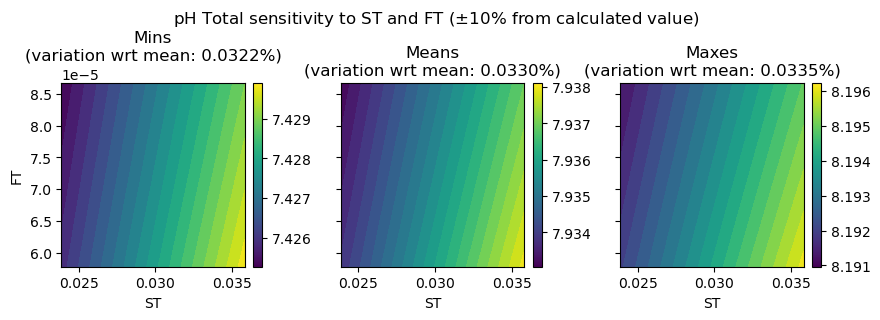

In [154]:

    
data_xa = analysis.create_st_ft_sensitivity_array(param_combinations, pertubation_percentage=20)


### visualise

mins = utils.select_by_stat(data_xa, {'salinity': 'min', 'temperature': 'min', 'ph_nbs': 'min'})
means = utils.select_by_stat(data_xa, {'salinity': 'mean', 'temperature': 'mean', 'ph_nbs': 'mean'})
maxs = utils.select_by_stat(data_xa, {'salinity': 'max', 'temperature': 'max', 'ph_nbs': 'max'})

# plot
fig, axs = plt.subplots(1, 3, figsize=(9,3), sharey=True)
for i, (data, param_type) in enumerate(zip([mins, means, maxs], ['Mins', 'Means', 'Maxes'])):
    axs[i].contourf(data.ST, data.FT, data, cmap='viridis', levels=20)
    # formatting
    # % variation from mean value
    variation = (data.max() - data.mean()) / data.mean() * 100
    
    axs[i].set_title(f"{param_type}\n(variation wrt mean: {variation:.4f}%)")
    axs[i].set_xlabel('ST')
    # add colorbar
    axs[i].figure.colorbar(
        plt.cm.ScalarMappable(norm=plt.Normalize(vmin=data.min(), vmax=data.max()), cmap='viridis'),
        ax=axs[i], fraction=0.046, pad=0.04
    )
    axs[i].set_box_aspect(1)
axs[0].set_ylabel('FT')
plt.suptitle('pH Total sensitivity to ST and FT ($\\pm$10% from calculated value)')
plt.tight_layout()